## Comparing different groups of experiments - wildtype


This notebook compares different groups of experiments, using the metrics described in each cell.

Each group takes a dictionary of `'experiment name': list[Experiment]`.
First, create each group by changing the experiment names in the lists on the next cell (lines 10 and 11), and then add each Group object to the `groups` list (last line of next cell).

In [2]:
%load_ext autoreload
%autoreload 2
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind

from pasna_analysis import DataLoader, Experiment, ExperimentConfig, Group


wt_config  = {
    '20240611_25C': ExperimentConfig(first_peak_threshold=30, to_exclude=[4,9,12,13,15,17,18,19,21,23]), 
    '20240919_25C': ExperimentConfig(first_peak_threshold=30, to_exclude=[2,5,6,7,11,14,16,18])
}

mut_config = {
}

wt_experiments = {}
for exp, config in wt_config.items():
    exp_path = Path.cwd().parent.joinpath('data', exp)
    wt_experiments[exp] = Experiment(DataLoader(exp_path), config.first_peak_threshold, config.to_exclude, dff_strategy='local_minima')

mut_experiments = {}
for exp, config in mut_config.items():
    exp_path = Path.cwd().parent.joinpath('data', exp)
    mut_experiments[exp] = Experiment(DataLoader(exp_path), config.first_peak_threshold, config.to_exclude, dff_strategy='local_minima')

wt = Group('wt', wt_experiments)
mut = Group('mutant', mut_experiments)

groups = [wt, mut]

20240919_25C  |  First peak detected before 30 mins for emb12 (t=2.3 mins). Skipping..


average peaks 13.0


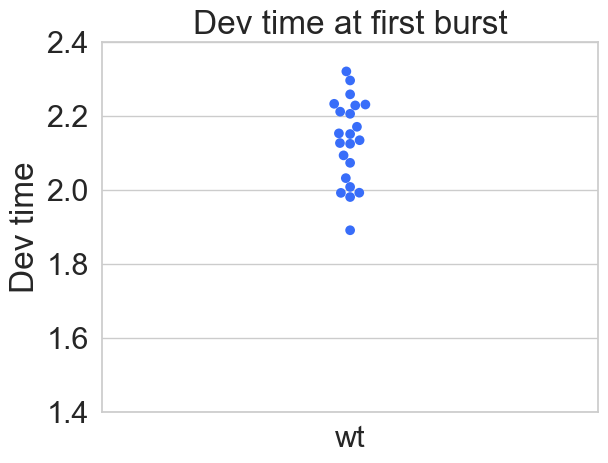

In [3]:
'''Developmental times at first peak.'''
data = {'dev_fp': [], 'group': []}

sum_peaks = 0
total_embs = 0
for group in groups: 
    for exp in group.experiments.values():
        for emb in exp.embryos:
            total_embs = total_embs + 1
            trace = exp.traces[emb.name]
            sum_peaks = sum_peaks + len(trace.peak_idxes)
            time_first_peak = trace.peak_times[0]
            dev_time_first_peak = emb.get_DT_from_time(time_first_peak)

            data['dev_fp'].append(dev_time_first_peak)
            data['group'].append(group.name)
print('average peaks', sum_peaks/total_embs)

df = pd.DataFrame(data)
group_avgs = {'group': [], 'fp_avg': []}

for group in groups:
    g = df[df['group']==group.name]
    group_avgs['group'].append(group.name)
    group_avgs['fp_avg'].append(g['dev_fp'].mean())

font_scale = 2
sns.set_theme(style='whitegrid', palette='rainbow', font_scale=font_scale)
# sns.catplot(group_avgs, x='group', y='fp_avg', kind='bar', width=0.2, linewidth=1, color='0.7')
ax = sns.swarmplot(data=data, x='group', y='dev_fp', hue='group', size=7)
ax.set(ylim=(1.4, 2.4))
ax.set_title('Dev time at first burst')
ax.set_ylabel('Dev time')
ax.set_xlabel('');
plt.savefig('wt_onsettime.svg')

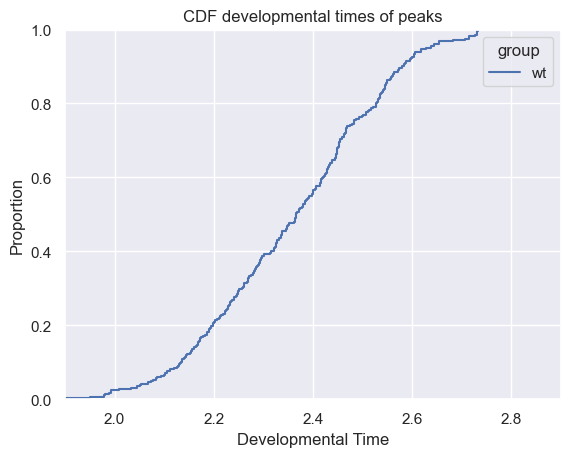

In [4]:
'''CDF of peak developmental times'''
data = {'dev_time': [], 'group': []}

for group in groups:
    for exp in group.experiments.values():
        for emb in exp.embryos:
            trace = exp.traces[emb.name]
            dev_times = [emb.get_DT_from_time(t) for t in trace.peak_times]
            data['dev_time'].extend(dev_times)
            data['group'].extend([group.name]*len(dev_times))

sns.set_theme(style='darkgrid')
ax = sns.ecdfplot(data=data, x='dev_time', hue='group')
ax.set_xlim([1.9, 2.9])
ax.set_title('CDF developmental times of peaks')
ax.set_ylabel('Proportion')
ax.set_xlabel('Developmental Time');


wt 8
wt 14


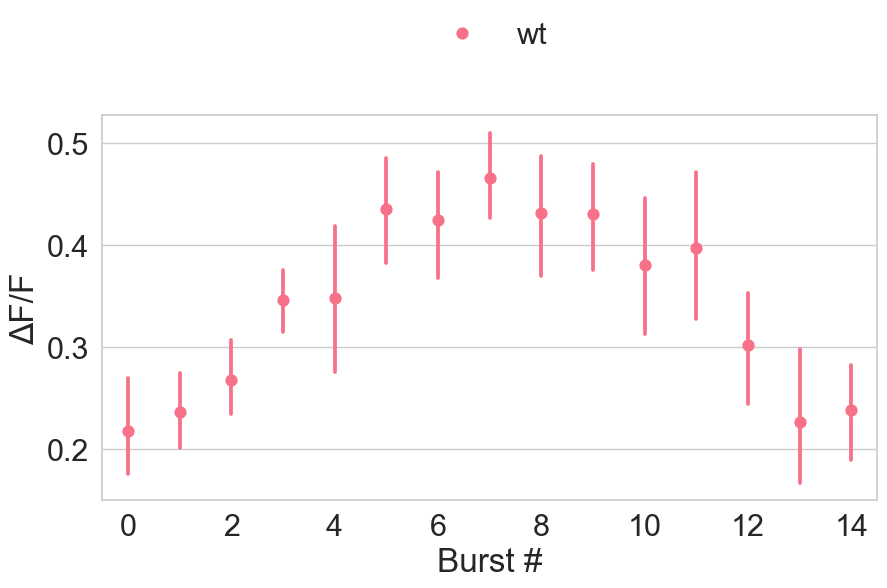

In [13]:
'''Peak amplitudes for each episode.'''
num_of_peaks = 15
data = {'peak_amp': [], 'group': [], 'peak_idx': []}

for group in groups:
    for exp in group.experiments.values():
        num = 0
        for emb in exp.embryos:
            num = num + 1
            t = exp.traces[emb.name]
            for i, amp in zip(range(num_of_peaks), t.peak_amplitudes):
                data['peak_amp'].append(amp)
                data['group'].append(group.name)
                data['peak_idx'].append(i)
        print(group.name, num)

amps = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(10, 5))

font_scale = 2
sns.set_theme(style='whitegrid', palette='husl', font_scale=font_scale)
ax = sns.pointplot(data=data, x='peak_idx', y='peak_amp', hue='group', linestyle='None')
ax.set_xticks([0, 2,4,6,8,10,12, 14])
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1.1), ncol=3, title=None, frameon=False,)
# ax.set_title(f'Burst amplitudes')
ax.set_xlabel('Burst #')
ax.set_ylabel('\u0394F/F');
plt.savefig('wt_amplitudes.svg')

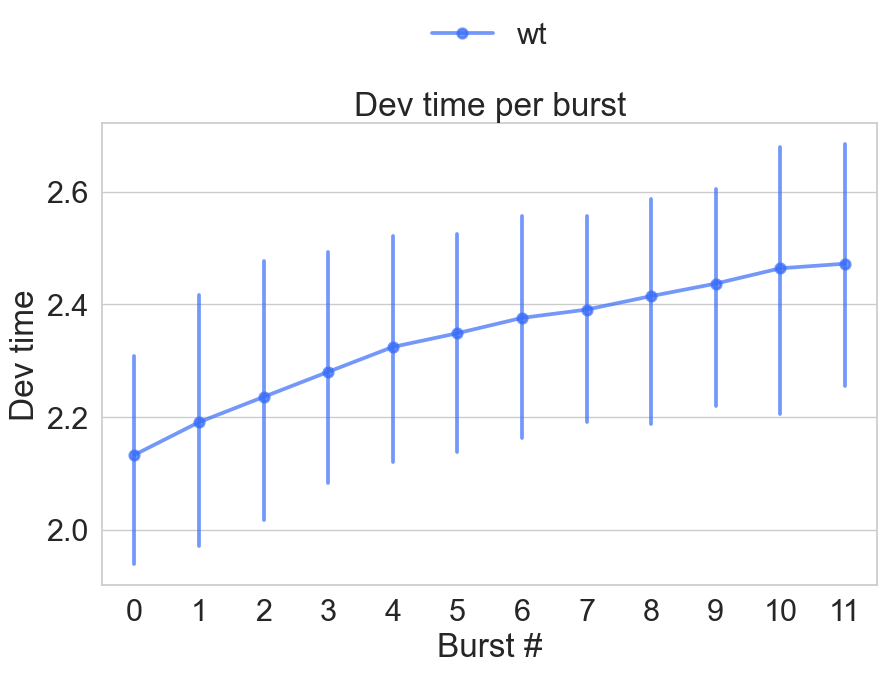

In [6]:
'''Developmental time for each episode.'''
data = {'group': [], 'dev_time': [], 'idx': []}

for group in groups:
    for exp in group.experiments.values():
        for emb_n, emb in enumerate(exp.embryos):
            trace = exp.traces[emb.name]
            for i, t in zip(range(12), trace.peak_times):
                data['group'].append(group.name)
                data['dev_time'].append(emb.get_DT_from_time(t))
                data['idx'].append(i)

dev_times = pd.DataFrame(data)


f, ax = plt.subplots(figsize=(10,6))
font_scale = 2
sns.set_theme(style='whitegrid', palette='rainbow', font_scale=font_scale)
ax = sns.pointplot(data=dev_times, x='idx', y='dev_time', hue='group', alpha=0.7, errorbar='pi')
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1.1), ncol=3, title=None, frameon=False,)
ax.set_title('Dev time per burst')
ax.set_xlabel('Burst #')
ax.set_ylabel('Dev time');

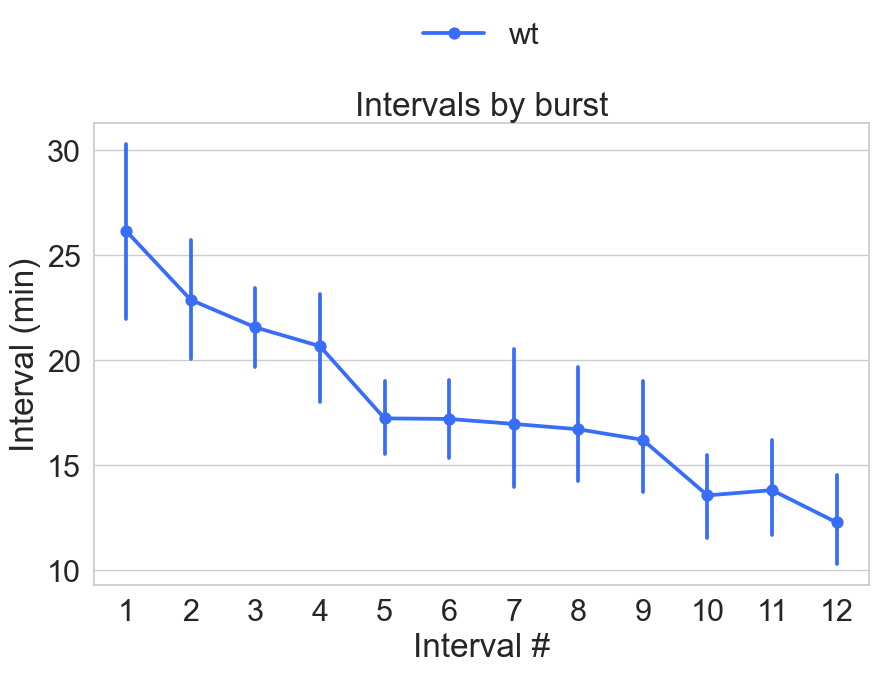

In [7]:
'''Intervals between each episode.'''
data = {'group': [], 'interval': [], 'idx': []}

for group in groups:
    for exp in group.experiments.values():
        for emb in exp.embryos:
            trace = exp.traces[emb.name]
            for i, interval in zip(range(12), trace.peak_intervals):
                data['group'].append(group.name)
                data['interval'].append(interval/60)
                data['idx'].append(i+1)

amps = pd.DataFrame(data)

f, ax = plt.subplots(figsize=(10,6))
font_scale = 2
sns.set_theme(style='whitegrid', palette='rainbow', font_scale=font_scale)
ax = sns.pointplot(data=amps, x='idx', y='interval', hue='group')
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1.1), ncol=3, title=None, frameon=False,)
ax.set_title('Intervals by burst')
ax.set_xlabel('Interval #')
ax.set_ylabel('Interval (min)');

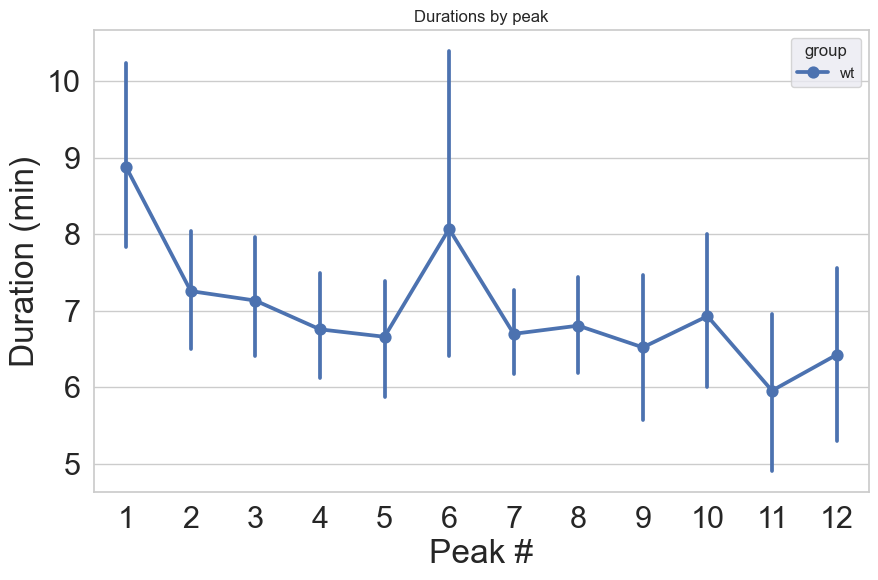

In [8]:
'''Duration of each peak.'''
data = {'group': [], 'duration': [], 'idx': []}

for group in groups:
    for exp in group.experiments.values():
        for emb in exp.embryos:
            trace = exp.traces[emb.name]
            for i, duration in zip(range(12), trace.peak_durations):
                data['group'].append(group.name)
                data['duration'].append(duration/60)
                data['idx'].append(i+1)

amps = pd.DataFrame(data)

f, ax = plt.subplots(figsize=(10,6))
sns.set_theme(style='darkgrid')
ax = sns.pointplot(data=amps, x='idx', y='duration', hue='group')
ax.set_title('Durations by peak')
ax.set_xlabel('Peak #')
ax.set_ylabel('Duration (min)');

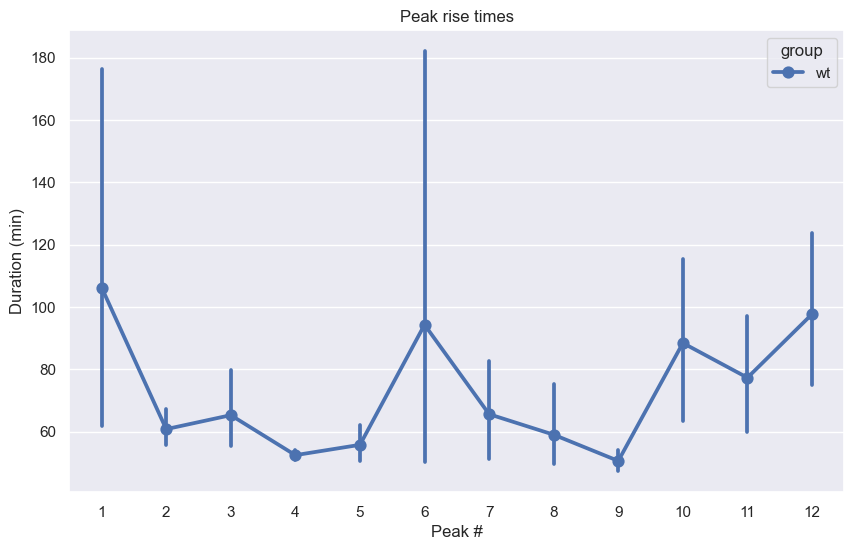

In [9]:
'''Rise times'''
data = {'group': [], 'rise_times': [], 'idx': []}

for group in groups:
    for exp in group.experiments.values():
        for emb in exp.embryos:
            trace = exp.traces[emb.name]
            for i, rise in zip(range(12), trace.peak_rise_times):
                data['group'].append(group.name)
                data['rise_times'].append(rise)
                data['idx'].append(i+1)

amps = pd.DataFrame(data)

f, ax = plt.subplots(figsize=(10,6))
sns.set_theme(style='darkgrid')
ax = sns.pointplot(data=amps, x='idx', y='rise_times', hue='group')
ax.set_title('Peak rise times')
ax.set_xlabel('Peak #')
ax.set_ylabel('Duration (min)');

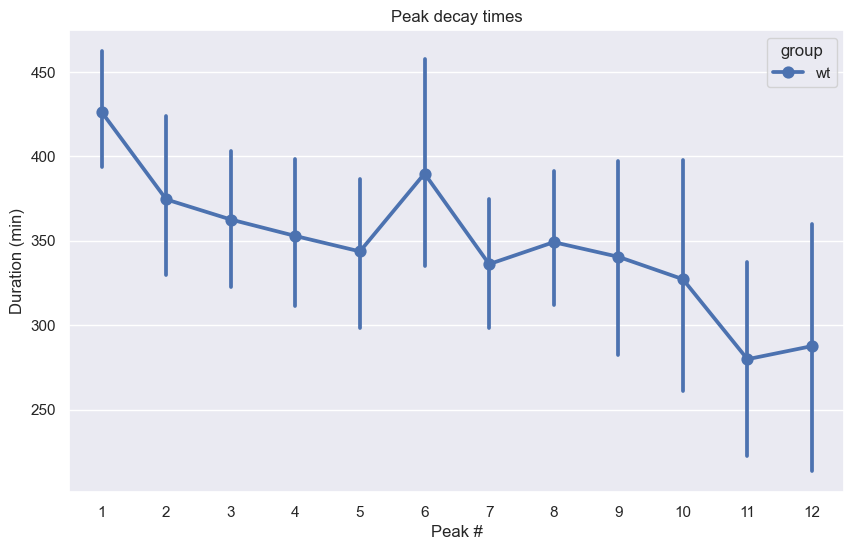

In [10]:
'''Decay times'''
data = {'group': [], 'decay_times': [], 'idx': []}

for group in groups:
    for exp in group.experiments.values():
        for emb in exp.embryos:
            trace = exp.traces[emb.name]
            for i, decay in zip(range(12), trace.peak_decay_times):
                data['group'].append(group.name)
                data['decay_times'].append(decay)
                data['idx'].append(i+1)

print(data['auc'])

amps = pd.DataFrame(data)

f, ax = plt.subplots(figsize=(10,6))
sns.set_theme(style='darkgrid')
ax = sns.pointplot(data=amps, x='idx', y='decay_times', hue='group')
ax.set_title('Peak decay times')
ax.set_xlabel('Peak #')
ax.set_ylabel('Duration (min)');

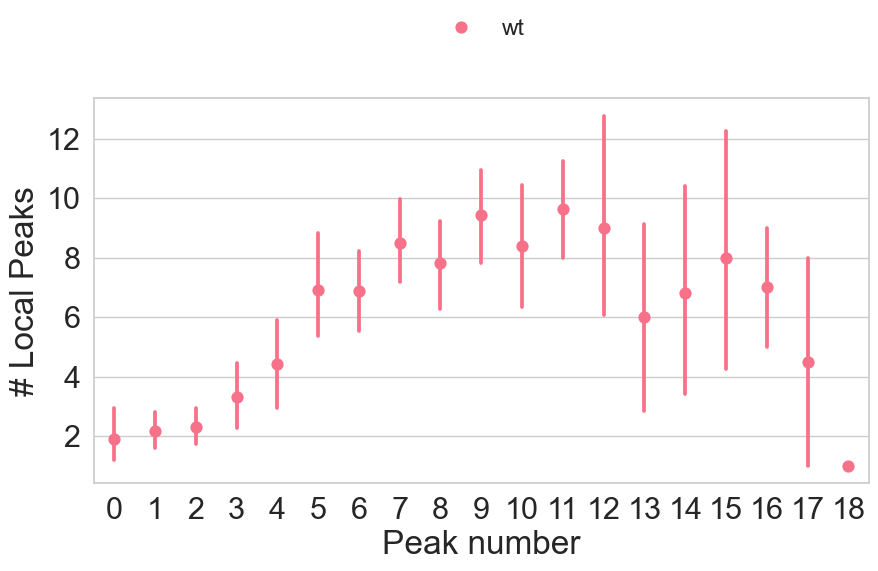

In [14]:
'''Local peaks for each peak.'''
data = {'group': [], 'num_local_peaks': [], 'peak': [], 'emb': []}

num_of_peaks = 22

for group in groups:
    for exp in group.experiments.values():
        
        for emb in exp.embryos:
            trace = exp.traces[emb.name]
            local_peaks = trace.compute_local_peaks(height=0.03, prominence=0.02)
            count_peaks = 0
            for i, lp in  enumerate(local_peaks):
                if count_peaks >= num_of_peaks:
                    break
                data['group'].append(group.name)
                data['num_local_peaks'].append(lp) 
                data['peak'].append(str(i)) 
                data['emb'].append(emb.name)
                count_peaks = count_peaks + 1

fig, ax = plt.subplots(figsize=(10, 5))

font_scale = 1.5
sns.set_theme(style='whitegrid', palette='husl', font_scale=font_scale)
ax = sns.pointplot(data=data, x='peak', y='num_local_peaks', hue='group', linestyle='None')
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1.1), ncol=3, title=None, frameon=False,)
# ax.set_xticks([0, 2,4,6,8,10,12, 14])
# ax.set(xlim=(-1, 15))
# ax.set_title('Local peaks during each burst')
ax.set_ylabel('# Local Peaks')
ax.set_xlabel('Peak number');
plt.savefig('wt_localpeaks.svg')